In [1]:
# In this example we will train 2 BDTs to differentiate between a CP-even and a CP-odd Higgs for the rhorho channel
# One BDT will use only 1 variable analogous to current methodology, the second BDT will include additional information
# to help improve the seperation 

In [2]:
!pip install --user scipy

In [3]:
!pip install --user uproot
!pip install --user vector 
!pip install --user --upgrade awkward

import sys
sys.path.append("/eos/home-m/qintong/.local/lib/python2.7/site-packages")

In [4]:
# !pip list

In [5]:
import uproot3 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt

import vector
import awkward as ak  # at least version 1.2.0
import numba as nb

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [6]:
import seaborn as sns
import scipy.stats as ss

In [7]:
# loading the tree
# tree = uproot3.open("/eos/user/q/qintong/SWAN_projects/Masters2021/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]
# tree2 = uproot3.open("/eos/user/q/qintong/SWAN_projects/Masters2021/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]

tree = uproot3.open("/eos/user/q/qintong/SWAN_projects/Masters2021/1_test/MVAFILE_DYJetsToLL-LO_2018_tt_28.root")["ntuple"]
#tree = uproot3.open("/eos/user/q/qintong/SWAN_projects/Masters2021/M2018_tt")["ntuple"]
tree2 = uproot3.open("/eos/user/q/qintong/SWAN_projects/Masters2021/1_test/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_2018_tt_28.root")["ntuple"]

In [8]:
# define what variables are to be read into the dataframe

# variables = [  "wt_cp_sm", "wt_cp_ps", "wt_cp_mm",
#                 "rand",
#                 "pt_1","pt_2",
#                 "met",
#                 "aco_angle_1", "aco_angle_5", "aco_angle_7", "aco_angle_6",
#                 "y_1_1", "y_1_2",
#                 "ip_sig_1", "ip_sig_2",
#                 "mva_dm_1","mva_dm_2",
#                 "tau_decay_mode_1","tau_decay_mode_2",
#                 "deepTauVsJets_medium_1","deepTauVsJets_medium_2",
#                 "deepTauVsEle_vvloose_1","deepTauVsEle_vvloose_2",
#                 "deepTauVsMu_vloose_1","deepTauVsMu_vloose_2",
#                 "trg_doubletau",
#              ]

variables = [ 'wt_cp_sm', 'wt_cp_ps', 'wt_cp_mm','rand',
            'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1',
            'pi2_px_1', 'pi2_py_1', 'pi2_pz_1', 'pi2_E_1',
            'pi3_px_1', 'pi3_py_1', 'pi3_pz_1', 'pi3_E_1', 
            'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2', 
            'pi2_px_2', 'pi2_py_2', 'pi2_pz_2', 'pi2_E_2', 
            'pi3_px_2', 'pi3_py_2', 'pi3_pz_2', 'pi3_E_2', 
            'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_1', 
            'pi0_px_2', 'pi0_py_2', 'pi0_pz_2', 'pi0_E_2', 
            'nu_px_1', 'nu_py_1', 'nu_pz_1', 'nu_E_1', 
            'nu_px_2', 'nu_py_2', 'nu_pz_2', 'nu_E_2', 
            'dm_1', 'dm_2',
#            'mass',
             'aco_angle_1','aco_angle_2',
             'costheta_1','costheta_tf_1',
             'costheta_2','costheta_tf_2',
             'q_1','q_2',
             'pv_aco_angle','pv_lin_angle','pv_aco_angle_vis'
             ]

df1 = tree.pandas.df(variables)

df2 = tree2.pandas.df(variables)

#combine VBF and ggH events

#df = pd.concat([df1,df2], ignore_index=True)
#print('{0}\n{1}\n{2}\n{3}'.format(A,B,C,D))
#df2['mass']
df2
#df2['dm_1'],df2['dm_2'] = df2["tau_decay_mode_1"],df2["tau_decay_mode_2"]

,wt_cp_sm,wt_cp_ps,wt_cp_mm,rand,pi_px_1,pi_py_1,pi_pz_1,pi_E_1,pi2_px_1,pi2_py_1,...,aco_angle_2,costheta_1,costheta_tf_1,costheta_2,costheta_tf_2,q_1,q_2,pv_aco_angle,pv_lin_angle,pv_aco_angle_vis
entry,,,,,,,,,,,,,,,,,,,,,
0,1.178117,0.469322,1.551740,0.809754,12.695847,-14.127764,14.703622,24.020704,0.000000,0.000000,...,3.587369,0.998773,0.474542,-0.996127,-0.066669,-1,1,1.044855,0.120737,-9999.0
1,1.934401,0.171453,0.739471,0.900160,-38.606248,-2.893735,-13.799608,41.100666,0.000000,0.000000,...,9999.000000,0.999232,-0.174065,0.999723,0.911762,-1,1,5.947131,3.122923,-9999.0
2,0.903949,1.011742,1.914172,0.827759,4.293776,-0.009378,-2.551309,4.996525,0.000000,0.000000,...,9999.000000,0.999736,0.725211,0.999736,0.161688,-1,1,1.631002,3.108153,-9999.0
3,1.869492,1.863629,1.801810,0.241744,-2.941166,15.142976,-24.919539,29.308072,0.000000,0.000000,...,9999.000000,0.999974,0.689197,NaN,NaN,-1,1,NaN,NaN,-9999.0
4,0.976774,1.218468,1.933734,0.922341,3.178904,-54.824202,-38.179448,66.884140,0.000000,0.000000,...,9999.000000,0.999720,-0.060085,0.998743,-0.446049,-1,1,1.730715,3.082836,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18684,1.888227,1.107123,1.811872,0.775297,-3.674501,-14.706136,4.429408,15.792768,-1.976414,-9.631377,...,9999.000000,0.999927,0.948803,-0.999629,-0.766824,1,-1,0.675623,0.037411,-9999.0
18685,0.045801,1.144370,0.804141,0.510265,-22.332202,-7.711140,12.247959,26.612420,0.000000,0.000000,...,4.839541,-0.999619,-0.405470,0.997810,0.589185,1,-1,1.272547,0.078853,-9999.0
18686,1.998883,1.618903,1.808742,0.179476,71.556994,-24.283660,-98.874493,124.443901,0.000000,0.000000,...,2.895988,0.999981,0.540555,-0.999933,-0.119859,-1,1,6.121637,0.017747,-9999.0


In [9]:
pi = (df1['dm_1']==0)&(df1['dm_2']==0)
rho = (df1['dm_1']==1)&(df1['dm_2']==1)
a1 = (df1['dm_1']==10)&(df1['dm_2']==10)

pi2 = (df2['dm_1']==0)&(df2['dm_2']==0)
rho2 = (df2['dm_1']==1)&(df2['dm_2']==1)
a12 = (df2['dm_1']==10)&(df2['dm_2']==10)

In [10]:
bins = 80
r= (0.,6.)

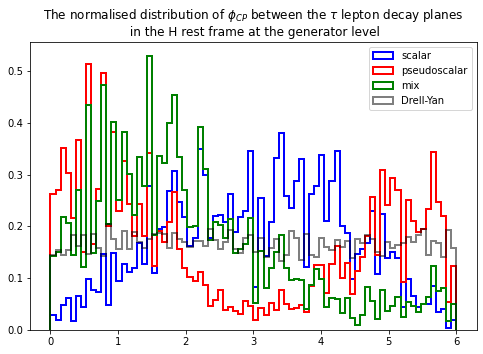

In [11]:
fig = plt.figure(figsize = (8,18))
plt.subplot(311)
plt.hist(df2[pi2]['aco_angle_1'],bins = bins,color='b',range=r,histtype=u'step',lw=2,weights=df2[pi2]['wt_cp_sm'],label='scalar',density = True)
plt.hist(df2[pi2]['aco_angle_1'],bins = bins,color='r',range=r,histtype=u'step',lw=2,weights=df2[pi2]['wt_cp_ps'],label='pseudoscalar',density = True)
plt.hist(df2[pi2]['aco_angle_1'],bins = bins,color='g',range=r,histtype=u'step',lw=2,weights=df2[pi2]['wt_cp_mm'],label='mix',density = True)
plt.hist(df1[pi]['aco_angle_1'],bins = bins,color='k',range=r,histtype=u'step',lw=2,label='Drell-Yan',density = True,alpha = 0.5)

plt.title('The normalised distribution of $\phi_{CP}$ between the $\\tau$ lepton decay planes \n in the H rest frame at the generator level')
plt.legend()

In [12]:
df_products = df2.iloc[:,0:32]
df_select = df2.loc[(df_products != 0).any(axis=1)]
df_select = df_select[(df_select['dm_1']<11)&(df_select['dm_2']<11)]
# df_select = df_select[(df_select['gen_nu_py_2']!=-9999)&(df_select['gen_nu_py_2']!=-9999)]
# df_select = df_select[(df_select['gen_nu_py_1']!=-9999)&(df_select['gen_nu_py_1']!=-9999)]

#df_select = df_select[(df_select['gen_match_1']==5)&(df_select['gen_match_2']==5)]
l = df_select.index.to_numpy()

a = []
b = []
c = []

for i in l:
    a.append(df2['dm_1'][i]) 
    b.append(df2['dm_2'][i])

# df_select['tau_1'],df_select['tau_2']= [a,b]
# df_select['tau_2'] = b
# df_select['mass'] = c
#df_select[(df_select['dm_1']==1)&(df_select['dm_2']==1)].sort_values(by=['pv_aco_angle'])

In [13]:
pis = (df_select['dm_1']==0)&(df_select['dm_2']==0)
rhos = (df_select['dm_1']==1)&(df_select['dm_2']==1)
a1s = (df_select['dm_1']==10)&(df_select['dm_2']==10)

Text(0, 0.5, 'costheta_tf_2')

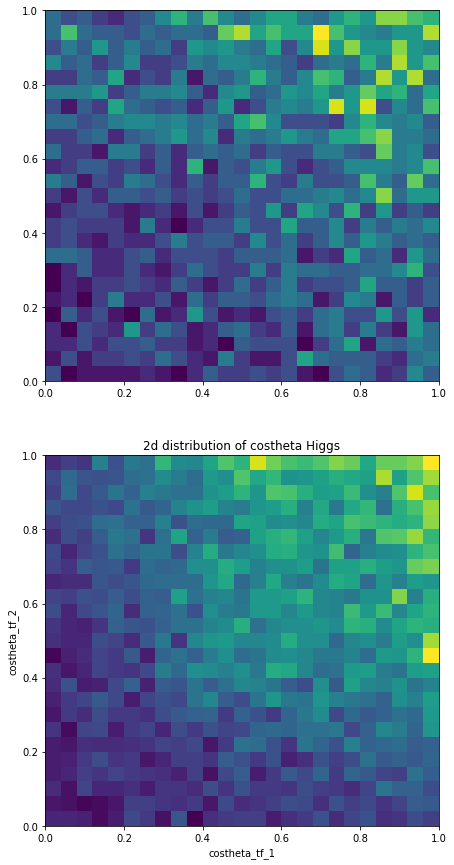

In [14]:
f, axs = plt.subplots(figsize=(24,15))
bins =25

plt.subplot(231)
plt.hist2d(df2[rhos]['costheta_tf_1'].values,df2[rhos]['costheta_tf_2'].values,bins, range = [[0.,1.],[0.,1.]],label = 'scalar')#,weights=(df2[pis]['wt_cp_sm']))#,density=True)
# plt.subplot(232)
# plt.hist2d(df2[pis]['costheta_tf_1'].to_numpy(),df2[pis]['costheta_tf_2'].to_numpy(),bins, range = [[0.,1.],[0.,1.]],label = 'pseudoscalar',weights=(df2[pis]['wt_cp_ps']))#,density=True)
# plt.subplot(233)
# plt.hist2d(df2[pis]['costheta_tf_1'].to_numpy(),df2[pis]['costheta_tf_2'].to_numpy(),bins, range = [[0.,1.],[0.,1.]],label = 'Mixed',weights=(df2[pis]['wt_cp_mm']))
plt.subplot(234)
plt.hist2d(df1[rho]['costheta_tf_1'].values,df1[rho]['costheta_tf_2'].values,bins, range = [[0.,1.],[0.,1.]],label = 'Drell-Yan')
#n,bin,patches = plt.hist(df1['pv_aco_angle'].to_numpy(),bins = 10, range = (0.,6.),alpha=0.5,label = 'Drell-Yan')
plt.title('2d distribution of costheta Higgs')
plt.xlabel('costheta_tf_1')
plt.ylabel('costheta_tf_2')

In [40]:
def four_vectors(arg,decaymode):
    pi_px =  pd.DataFrame(df_select[arg[0]].iloc[decaymode]).values
    p0_px = pd.DataFrame(df_select[arg[8]].iloc[decaymode]).values
    nu_px =  pd.DataFrame(df_select[arg[4]].iloc[decaymode]).values
    rho_px = pi_px+p0_px
    tau_px = pi_px+p0_px+nu_px

    pi_py =  pd.DataFrame(df_select[arg[1]].iloc[decaymode]).values
    p0_py = pd.DataFrame(df_select[arg[9]].iloc[decaymode]).values
    nu_py =  pd.DataFrame(df_select[arg[5]].iloc[decaymode]).values
    rho_py = pi_py+p0_py
    tau_py = pi_py+p0_py+nu_py

    pi_pz =  pd.DataFrame(df_select[arg[2]].iloc[decaymode]).values
    p0_pz = pd.DataFrame(df_select[arg[10]].iloc[decaymode]).values
    nu_pz =  pd.DataFrame(df_select[arg[6]].iloc[decaymode]).values
    rho_pz = pi_pz+p0_pz
    tau_pz = pi_pz+p0_pz+nu_pz
    
    pi_E = pd.DataFrame(df_select[arg[3]].iloc[decaymode]).values
    p0_E = pd.DataFrame(df_select[arg[11]].iloc[decaymode]).values
    nu_E = vector.obj(x=nu_px, y=nu_py, z=nu_pz).mag
    rho_E = pi_E+p0_E
    tau_E = pi_E+p0_E+nu_E
    
    pis = []
    p0s = []
    nus = []
    rhos = []
    tau = []
    for i in range(len(pi_px)):
        a = vector.obj(x = float(pi_px[i]), y = float(pi_py[i]), z = float(pi_pz[i]), E = float(pi_E[i]))
        b = vector.obj(x = float(p0_px[i]), y = float(p0_py[i]), z = float(p0_pz[i]), E = float(p0_E[i]))
        c = vector.obj(x = float(nu_px[i]), y = float(nu_py[i]), z = float(nu_pz[i]), E = float(nu_E[i]))
        d = vector.obj(x = float(tau_px[i]), y = float(tau_py[i]), z = float(tau_pz[i]), E = float(tau_E[i]))
        e = vector.obj(x = float(rho_px[i]), y = float(rho_py[i]), z = float(rho_pz[i]), E = float(rho_E[i]))
        pis.append(a)
        p0s.append(b)
        nus.append(c)
        tau.append(d)
        rhos.append(e)
    
    return pis, p0s, nus, rhos, tau

In [17]:
def four_vectors_pi_decay(arg,decaymode):
    pi_px =  pd.DataFrame(df_select[arg[0]].iloc[decaymode]).values
    nu_px =  pd.DataFrame(df_select[arg[4]].iloc[decaymode]).values
    tau_px = pi_px+nu_px

    pi_py =  pd.DataFrame(df_select[arg[1]].iloc[decaymode]).values
    #p0_py = pd.DataFrame(X_test_inv_o[arg[9]].iloc[decaymode]).values
    nu_py =  pd.DataFrame(df_select[arg[5]].iloc[decaymode]).values
    tau_py = pi_py+nu_py

    pi_pz =  pd.DataFrame(df_select[arg[2]].iloc[decaymode]).values
    #p0_pz = pd.DataFrame(X_test_inv_o[arg[10]].iloc[decaymode]).values
    nu_pz =  pd.DataFrame(df_select[arg[6]].iloc[decaymode]).values
    tau_pz = pi_pz+nu_pz
    
    pi_E = pd.DataFrame(df_select[arg[3]].iloc[decaymode]).values
    #p0_E = pd.DataFrame(X_test_inv_o[arg[11]].iloc[decaymode]).values
    nu_E = pd.DataFrame(df_select[arg[7]].iloc[decaymode]).values
    tau_E = pi_E+nu_E
    
    
    pis = []
    #p0s = []
    nus = []
    tau = []
    for i in range(len(pi_px)):
        a = vector.obj(x = np.float64(pi_px[i]), y = np.float64(pi_py[i]), z = np.float64(pi_pz[i]), E = np.float64(pi_E[i]))
        #b = vector.obj(x = float(p0_px[i]), y = float(p0_py[i]), z = float(p0_pz[i]), E = float(p0_E[i]))
        c = vector.obj(x = np.float64(nu_px[i]), y = np.float64(nu_py[i]), z = np.float64(nu_pz[i]), E = np.float64(nu_E[i]))
        d = vector.obj(x = np.float64(tau_px[i]), y = np.float64(tau_py[i]), z = np.float64(tau_pz[i]), E = np.float64(tau_E[i]))
        pis.append(a)
        #p0s.append(b)
        nus.append(c)
        tau.append(d)
    
    return pis, nus, tau

In [18]:
var_pv_pi_1 = ['pi_px_1','pi_py_1','pi_pz_1','pi_E_1',
            'nu_px_1','nu_py_1','nu_pz_1','nu_E_1',]

var_pv_pi_2 = ['pi_px_2','pi_py_2','pi_pz_2','pi_E_2',
            'nu_px_2','nu_py_2','nu_pz_2','nu_E_2',]

In [19]:
# index_name_pi_1 = df_select[(df_select['dm_1']==0)].index
# index_name_rho_1 = df_select[(df_select['dm_1']==1)].index
# index_name_a1_1 = df_select[(df_select['dm_1']==10)].index

# index_name_pi_2 = df_select[(df_select['dm_2']==0)].index
# index_name_rho_2 = df_select[(df_select['dm_2']==1)].index
# index_name_a1_2 = df_select[(df_select['dm_2']==10)].index

index_name_pi = df_select[(df_select['dm_1']==0)&(df_select['dm_2']==0)].index
index_name_rho = df_select[(df_select['dm_1']==1)&(df_select['dm_2']==1)].index
index_name_a1 = df_select[(df_select['dm_1']==10)&(df_select['dm_2']==10)].index

In [20]:
pi_pi_1,nu_pi_1,tau_pi_1 = four_vectors_pi_decay(var_pv_pi_1,index_name_pi)
pi_pi_2,nu_pi_2,tau_pi_2 = four_vectors_pi_decay(var_pv_pi_2,index_name_pi)

In [21]:
var_pv_1 = ['pi_px_1','pi_py_1','pi_pz_1','pi_E_1',
            'nu_px_1','nu_py_1','nu_pz_1','nu_E_1',
            'pi0_px_1','pi0_py_1','pi0_pz_1','pi0_E_1']

var_pv_2 = ['pi_px_2','pi_py_2','pi_pz_2','pi_E_2',
            'nu_px_2','nu_py_2','nu_pz_2','nu_E_2',
            'pi0_px_2','pi0_py_2','pi0_pz_2','pi0_E_2']

In [22]:
# boost = vector.obj(px=tau_rho_1[0].px/tau_rho_1[0].E,py=tau_rho_1[0].py/tau_rho_1[0].E,pz=tau_rho_1[0].pz/tau_rho_1[0].E)
# p = pi_rho_1[0].boost_beta3(-boost)
# p

In [23]:
# def IPAcoAngle(pv,undecayed_taus):#pi_p0_1, out_2, pi_pi_1, tau_pi_2)
#     ang = []
#     #dot = []
#     for i in range(len(undecayed_taus[0])):
#         b = undecayed_taus[0][i]+undecayed_taus[1][i]
#         boost = vector.obj(px=b.px/b.E,py=b.py/b.E,pz=b.pz/b.E)
#         p1_b = pv[0][i].boost(-boost)
#         p2_b = pv[1][i].boost(-boost)
#         p3_b = undecayed_taus[0][i].boost(-boost)
#         p4_b = undecayed_taus[1][i].boost(-boost)

#         n1 = p1_b - (p1_b.dot(p3_b/p3_b.mag))*(p3_b/p3_b.mag)
#         n2 = p2_b - (p2_b.dot(p4_b/p4_b.mag))*(p4_b/p4_b.mag)

#         n1 = n1/n1.mag
#         n2 = n2/n2.mag

#         sign = (p4_b/p4_b.mag).dot(n1.cross(n2))
#         pva = np.arccos(n1.dot(n2))
#         #dot.append(n1.dot(n2))
#         if sign<0:
#             ang.append(2*np.pi - pva)
            
#         else:
#             ang.append(pva)
        
#     return ang

In [24]:
# boost = vector.obj(px=tau_rho_1[20].px/tau_rho_1[20].E, py=tau_rho_1[20].py/tau_rho_1[20].E, pz=tau_rho_1[20].pz/tau_rho_1[20].E)
# pi_d = pi_rho_1[20].boost_beta3(-boost)
# p0_d = p0_rho_1[20].boost_beta3(-boost)
# undecayed_tau_d = tau_rho_1[20].boost_beta3(-boost)

# q = pi_d-p0_d
# P = undecayed_tau_d
# N = undecayed_tau_d-pi_d-p0_d
# pv=P.mass*(2*(q.dot(N))*q - q.mag2*N)*(1/ (2*(q.dot(N))*(q.dot(P)) - q.mag2*(N.dot(P))))

# pv

In [25]:
# boost = vector.obj(px=tau_rho_1[1].px/tau_rho_1[1].E, py=tau_rho_1[1].py/tau_rho_1[1].E, pz=tau_rho_1[1].pz/tau_rho_1[1].E)
# pi_d = pi_rho_1[1].boost_beta3(-boost)
# p0_d = p0_rho_1[1].boost_beta3(-boost)
# undecayed_tau_d = tau_rho_1[1].boost_beta3(-boost)

# q = pi_d-p0_d
# P = undecayed_tau_d
# N = undecayed_tau_d-pi_d-p0_d
# pv=P.mag*(2*(q.dot(N))*q - q.mag2*N)*(1/ (2*(q.dot(N))*(q.dot(P)) - q.mag2*(N.dot(P))))

# undecayed_tau_d

In [26]:
def PolarimetricVector(arg,undecayed_tau):
    pv = []
    for i in range(len(undecayed_tau)):
        boost = vector.obj(px=undecayed_tau[i].px/undecayed_tau[i].E,py=undecayed_tau[i].py/undecayed_tau[i].E,pz=undecayed_tau[i].pz/undecayed_tau[i].E)
        if len(arg) == 1:
            ot = arg[0][i].boost_beta3(-boost).to_beta3()
            pv_2 = vector.obj(px=ot.px,py=ot.py,pz=ot.pz,E=0)
            pv_3 = pv_2.boost_beta3(boost)
            pv.append(pv_3)
            
        elif len(arg) == 2:
            pi_d = arg[0][i].boost_beta3(-boost)
            p0_d = arg[1][i].boost_beta3(-boost)
            undecayed_tau_d = undecayed_tau[i].boost_beta3(-boost)

            q = pi_d-p0_d
            P = undecayed_tau_d
            N = undecayed_tau_d-pi_d-p0_d
            pv_1 = P.mass*(2*(q.dot(N))*q.to_beta3() - q.mag2*N.to_beta3())*(1/ (2*(q.dot(N))*(q.dot(P)) - q.mag2*(N.dot(P))))
            pv_2 = vector.obj(px=pv_1.px,py=pv_1.py,pz=pv_1.pz,E=0)
            pv_3 = pv_2.boost_beta3(boost)
            pv.append(pv_3)
            
        #else:
            
            
        #         P.M()*(2*(q*N)*q.Vect() - q.Mag2()*N.Vect()) * (1/ (2*(q*N)*(q*P) - q.Mag2()*(N*P)))
        #pv.append(P.mag*(2*(q.dot(N)*q))*(1/(2*(q.dot(N)*(q.dot(P))))))
        #         P.M()*(2*(q*N)*q.Vect()) * (1/ (2*(q*N)*(q*P)))
    return pv

In [93]:
def PolarimetricVector_t(arg,undecayed_tau,n):
    boost = vector.obj(px=undecayed_tau[n].px/undecayed_tau[n].E,py=undecayed_tau[n].py/undecayed_tau[n].E,pz=undecayed_tau[n].pz/undecayed_tau[n].E)
    if len(arg) == 1:
        ot = arg[0][n].boost_beta3(-boost).to_beta3()
        pv_2 = vector.obj(px=ot.px,py=ot.py,pz=ot.pz,E=0)
        pv_3 = pv_2.boost_beta3(boost)
        pv=pv_3

    elif len(arg) == 2:
        pi_d = arg[0][n].boost_beta3(-boost)
        p0_d = arg[1][n].boost_beta3(-boost)
        undecayed_tau_d = undecayed_tau[n].boost_beta3(-boost)

        q = pi_d-p0_d
        P = undecayed_tau_d
        N = undecayed_tau_d-pi_d-p0_d
        pv_1 = P.mass*(2*(q.dot(N))*q.to_beta3() - q.mag2*N.to_beta3())*(1/ (2*(q.dot(N))*(q.dot(P)) - q.mag2*(N.dot(P))))
        pv_2 = vector.obj(px=pv_1.px,py=pv_1.py,pz=pv_1.pz,E=0)
        pv_3 = pv_2.boost_beta3(boost)
        pv=pv_3
            
        #else:
            
            
        #         P.M()*(2*(q*N)*q.Vect() - q.Mag2()*N.Vect()) * (1/ (2*(q*N)*(q*P) - q.Mag2()*(N*P)))
        #pv.append(P.mag*(2*(q.dot(N)*q))*(1/(2*(q.dot(N)*(q.dot(P))))))
        #         P.M()*(2*(q*N)*q.Vect()) * (1/ (2*(q*N)*(q*P)))
    return pv

In [100]:
t_1 = PolarimetricVector_t([pi_rho_1,p0_rho_1],tau_rho_1,10)
#t_2 = PolarimetricVector_t([pi_rho_1,p0_rho_1],tau_rho_1,1)

In [101]:
t_1

vector.obj(px=11.635452962725537, py=3.868279553287053, pz=-10.710382062942529, E=15.22306672327096)

In [103]:
pv_rho[0][10]

vector.obj(px=11.635452962725537, py=3.868279553287053, pz=-10.710382062942529, E=15.22306672327096)

In [27]:
#     } else if (pis.size()==3 && pi0s.size()==0) {
#       std::vector<TLorentzVector> TauA1andProd;

#       if(pis[1]->charge()==pis[2]->charge()) {
#         TauA1andProd = {
#           ConvertToLorentz(tau->vector()),
#           ConvertToLorentz(pis[0]->vector()),
#           ConvertToLorentz(pis[1]->vector()),
#           ConvertToLorentz(pis[2]->vector())
#         };
#       } else if(pis[0]->charge()==pis[2]->charge()) {
#         TauA1andProd = {
#           ConvertToLorentz(tau->vector()),
#           ConvertToLorentz(pis[1]->vector()),
#           ConvertToLorentz(pis[0]->vector()),
#           ConvertToLorentz(pis[2]->vector())
#         };
#       } else if(pis[0]->charge()==pis[1]->charge()) {
#         TauA1andProd = {
#           ConvertToLorentz(tau->vector()),
#           ConvertToLorentz(pis[2]->vector()),
#           ConvertToLorentz(pis[0]->vector()),
#           ConvertToLorentz(pis[1]->vector())
#         };
#       }
#       for (unsigned i=0; i<TauA1andProd.size(); ++i) TauA1andProd[i].Boost(-boost);
#       PolarimetricA1  a1pol;
#       a1pol.Configure(TauA1andProd,tau->charge());
#       TLorentzVector l_out = -a1pol.PVC();
#       l_out.Boost(boost);
#       return l_out;

In [124]:
def IPAcoAngle(pv,undecayed_taus):
    #pi_p0_1, out_2, pi_pi_1, tau_pi_2):
    ang = []
    out = []
    for i in range(len(undecayed_taus[0])):
        b = undecayed_taus[0][i]+undecayed_taus[1][i]
        boost = vector.obj(px=b.px/b.E,py=b.py/b.E,pz=b.pz/b.E)
#         l_h1= PolarimetricVector(pis[0], pi0s[0], undecayed_taus[0])
#         l_h2= PolarimetricVector(pis[1], pi0s[1], undecayed_taus[1])
        l_h1= pv[0]
        l_h2= pv[1]
        l_tau_1 = undecayed_taus[0]
        l_tau_2 = undecayed_taus[1]

        p1_b = l_h1[i].boost_beta3(-boost)
        p2_b = l_h2[i].boost_beta3(-boost)

        p3_b = l_tau_1[i].boost_beta3(-boost)
        p4_b = l_tau_2[i].boost_beta3(-boost)

        h1 = p1_b.to_beta3()/p1_b.to_beta3().mag
        h2 = p2_b.to_beta3()/p2_b.to_beta3().mag

        n1 = p3_b.to_beta3()/p3_b.to_beta3().mag
        n2 = p4_b.to_beta3()/p4_b.to_beta3().mag

        k1 = (h1.cross(n1))/((h1.cross(n1)).mag)
        k2 = (h2.cross(n2))/((h2.cross(n2)).mag)
        
        #out.append(h1)

        # pv_lin_angle_ = acos(h1.Dot(h2))
        pva = np.arccos(k1.dot(k2))
        pv_sign = (h1.cross(h2)).dot(n1)

        
        if pv_sign>0:
            ang.append(2*np.pi-pva)
        else: 
            ang.append(pva)
        
        
    return ang

In [135]:
def IPAcoAngle_t(pv,undecayed_taus,i):
    #pi_p0_1, out_2, pi_pi_1, tau_pi_2):

    b = undecayed_taus[0][i]+undecayed_taus[1][i]
    boost = vector.obj(px=b.px/b.E,py=b.py/b.E,pz=b.pz/b.E)
#         l_h1= PolarimetricVector(pis[0], pi0s[0], undecayed_taus[0])
#         l_h2= PolarimetricVector(pis[1], pi0s[1], undecayed_taus[1])
    l_h1= pv[0]
    l_h2= pv[1]
    l_tau_1 = undecayed_taus[0]
    l_tau_2 = undecayed_taus[1]

    p1_b = l_h1[i].boost_beta3(-boost)
    p2_b = l_h2[i].boost_beta3(-boost)

    p3_b = l_tau_1[i].boost_beta3(-boost)
    p4_b = l_tau_2[i].boost_beta3(-boost)

    h1 = p1_b.to_beta3()/p1_b.to_beta3().mag
    h2 = p2_b.to_beta3()/p2_b.to_beta3().mag

    n1 = p3_b.to_beta3()/p3_b.to_beta3().mag
    n2 = p4_b.to_beta3()/p4_b.to_beta3().mag

    k1 = (h1.cross(n1))/((h1.cross(n1)).mag)
    k2 = (h2.cross(n2))/((h2.cross(n2)).mag)

    #out.append(h1)

    # pv_lin_angle_ = acos(h1.Dot(h2))
    pva = np.arccos(k1.dot(k2))
    pv_sign = (h1.cross(h2)).dot(n1)


    if pv_sign>0:
        ang=2*np.pi-pva
    else: 
        ang=pva
            
        
    return ang

In [136]:
rho_1_t = IPAcoAngle_t(pv_rho,tau_rho,10)

In [137]:
rho_1_t

5.250214191247442

In [134]:
a[10]

5.250214191247442

In [70]:
def IPAcoAngle_vis_vis(pv,undecayed_taus,cp_sign_1,cp_sign_2):
    #pi_p0_1, out_2, pi_pi_1, tau_pi_2):
    ang = []
    out = []
    for i in range(len(undecayed_taus[0])):
        b = undecayed_taus[0][i]+undecayed_taus[1][i]
        boost = vector.obj(px=b.px/b.E,py=b.py/b.E,pz=b.pz/b.E)
#         l_h1= PolarimetricVector(pis[0], pi0s[0], undecayed_taus[0])
#         l_h2= PolarimetricVector(pis[1], pi0s[1], undecayed_taus[1])
        l_h1= pv[0]
        l_h2= pv[1]
        l_tau_1 = undecayed_taus[0]
        l_tau_2 = undecayed_taus[1]

        p1_b = l_h1[i].boost_beta3(-boost)
        p2_b = l_h2[i].boost_beta3(-boost)

        p3_b = l_tau_1[i].boost_beta3(-boost)
        p4_b = l_tau_2[i].boost_beta3(-boost)

        h1 = p1_b.to_beta3()/p1_b.to_beta3().mag
        h2 = p2_b.to_beta3()/p2_b.to_beta3().mag

        n1 = p3_b.to_beta3()/p3_b.to_beta3().mag
        n2 = p4_b.to_beta3()/p4_b.to_beta3().mag

        k1 = (h1.cross(n1))/((h1.cross(n1)).mag)
        k2 = (h2.cross(n2))/((h2.cross(n2)).mag)
        
        #out.append(h1)

        # pv_lin_angle_ = acos(h1.Dot(h2))
        pva = np.arccos(k1.dot(k2))
        pv_sign = (h1.cross(h2)).dot(n1)
        cp_sign = cp_sign_1[i]*cp_sign_2[i]
        
        if pv_sign>0:
            pva_1 = 2*np.pi-pva
        else: 
            pva_1 = pva
            
        if cp_sign<0:
            if pva_1<np.pi:
                ang.append(pva_1 + np.pi)
            else:
                ang.append(pva_1 - np.pi)
        else:
            ang.append(pva_1)
        
    return ang

In [71]:
pi_rho_1,p0_rho_1,nu_rho_1,rho_rho_1,tau_rho_1 = four_vectors(var_pv_1,index_name_rho)
pi_rho_2,p0_rho_2,nu_rho_2,rho_rho_2,tau_rho_2 = four_vectors(var_pv_2,index_name_rho)

In [72]:
pv_pi_1 = PolarimetricVector([pi_pi_1],tau_pi_1)
pv_pi_2 = PolarimetricVector([pi_pi_2],tau_pi_2)
pv_rho_1 = PolarimetricVector([pi_rho_1,p0_rho_1],tau_rho_1)
pv_rho_2 = PolarimetricVector([pi_rho_2,p0_rho_2],tau_rho_2)

In [73]:
pi_rho = [pi_rho_1,pi_rho_2]
p0_rho = [p0_rho_1,p0_rho_2]
rho_rho = [rho_rho_1,rho_rho_2]
tau_rho = [tau_rho_1,tau_rho_2]
pv_rho = [pv_rho_1,pv_rho_2]

pi_pi = [pi_pi_1,pi_pi_2]
tau_pi = [tau_pi_1,tau_pi_2]
pv_pi = [pv_pi_1,pv_pi_2]

In [125]:
a= IPAcoAngle(pv_rho,tau_rho)
#a_2= IPAcoAngle(pv_pi,tau_pi)

In [75]:
def Yrho(pi,pi0,taus):
    y_sign = []
    for i in range(len(taus)):
        E_pi = pi[i].E
        E_pi0 = pi0[i].E
        y = (E_pi-E_pi0)/(E_pi+E_pi0)
        y_sign.append(y)
    return y_sign
    

In [76]:
# cp_sign_pirho = Yrho(pi_rho_2_pirho,p0_rho_2_pirho,tau_rho_2_pirho)
# cp_sign_rhopi = Yrho(pi_rho_1_rhopi,p0_rho_1_rhopi,tau_rho_1_rhopi)
cp_sign_rho_1 = Yrho(pi_rho_1,p0_rho_1,tau_rho_1)
cp_sign_rho_2 = Yrho(pi_rho_2,p0_rho_2,tau_rho_2)

In [77]:
v_r = IPAcoAngle_vis_vis(rho_rho,tau_rho,cp_sign_rho_1,cp_sign_rho_2)

In [126]:
df_new_2 = df_select.loc[index_name_rho]
df_new_2['computed_pv_angle'] = a
df_sorted_2 = df_new_2[['computed_pv_angle','pv_aco_angle','wt_cp_sm', 'wt_cp_ps', 'wt_cp_mm']].sort_values(by=['pv_aco_angle'])
b = df_new_2.sort_values(by=['computed_pv_angle'])['computed_pv_angle'].values

df_sorted_2['sorted_pv_angle'] = b

In [86]:
df_new_1 = df_select.loc[index_name_rho]
df_new_1['computed_pv_angle'] = v_r
df_sorted_1 = df_new_1[['computed_pv_angle','pv_aco_angle','wt_cp_sm', 'wt_cp_ps', 'wt_cp_mm']].sort_values(by=['pv_aco_angle'])
b1 = df_new_1.sort_values(by=['computed_pv_angle'])['computed_pv_angle'].values

df_sorted_1['sorted_pv_angle'] = b1

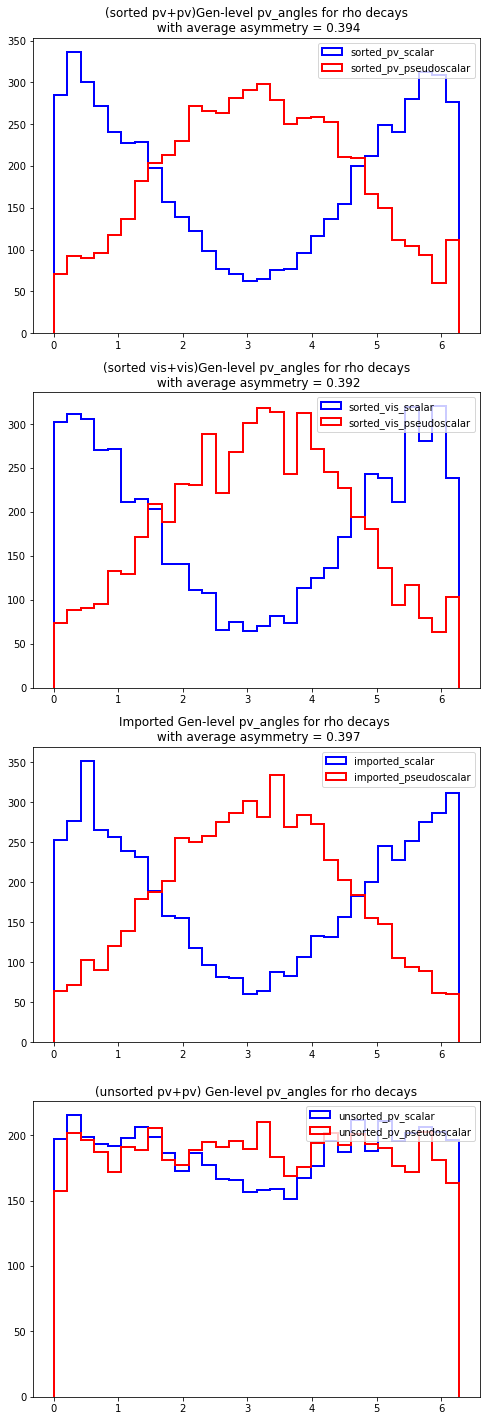

In [147]:
r = (0,2*np.pi)
bins = 30

# fig = plt.figure(figsize = (8,18))
# plt.subplot(311)
# plt.hist(df_sorted_2['sorted_pv_angle'],bins = bins,range=r,histtype=u'step',lw=2,weights=df_sorted_2['wt_cp_sm'],label='computed_scalar')
# plt.hist(df_sorted_2['sorted_pv_angle'],bins = bins,range=r,histtype=u'step',lw=2,weights=df_sorted_2['wt_cp_ps'],label='computed_pseudoscalar')
# #plt.hist(df_sorted_2['sorted_pv_angle'],bins = bins,range=r,histtype=u'step',lw=2,weights=df_sorted_2['wt_cp_mm'],label='computed_mix')
# plt.title('computed Gen-level pv_angles for rho decays')
# plt.legend()

fig = plt.figure(figsize = (8,25))
plt.subplot(411)
n_sm_ml_rho,bins_sm_ml,p = plt.hist(df_sorted_2['sorted_pv_angle'],bins = bins,color = 'b',range=r,histtype=u'step',lw=2,weights=df_sorted_2['wt_cp_sm'],label='sorted_pv_scalar')
n_ps_ml_rho,bins_ps_ml,p = plt.hist(df_sorted_2['sorted_pv_angle'],bins = bins,color = 'r',range=r,histtype=u'step',lw=2,weights=df_sorted_2['wt_cp_ps'],label='sorted_pv_pseudoscalar')
ml_sep_rho = (1/bins)*(sum(abs(n_sm_ml_rho-n_ps_ml_rho)/(n_sm_ml_rho+n_ps_ml_rho)))
#plt.hist(df_sorted_2['sorted_pv_angle'],bins = bins,range=r,histtype=u'step',lw=2,weights=df_sorted_2['wt_cp_mm'],label='computed_mix')
plt.title('(sorted pv+pv)Gen-level pv_angles for rho decays\n with average asymmetry = {0:.3f}'.format(ml_sep_rho))
plt.legend()

plt.subplot(412)
n_sm_vis_rho,bins_sm_vis,p = plt.hist(df_sorted_1['sorted_pv_angle'],bins = bins,color = 'b',range=r,histtype=u'step',lw=2,weights=df_sorted_1['wt_cp_sm'],label='sorted_vis_scalar')
n_ps_vis_rho,bins_sm_vis,p = plt.hist(df_sorted_1['sorted_pv_angle'],bins = bins,color = 'r',range=r,histtype=u'step',lw=2,weights=df_sorted_1['wt_cp_ps'],label='sorted_vis_pseudoscalar')
#plt.hist(df_sorted_2['sorted_pv_angle'],bins = bins,range=r,histtype=u'step',lw=2,weights=df_sorted_2['wt_cp_mm'],label='computed_mix')
vis_sep_rho = (1/bins)*(sum(abs(n_sm_vis_rho-n_ps_vis_rho)/(n_sm_vis_rho+n_ps_vis_rho)))
plt.title('(sorted vis+vis)Gen-level pv_angles for rho decays\n with average asymmetry = {0:.3f}'.format(vis_sep_rho))
plt.legend()

# plt.subplot(312)
# plt.hist(df_new_2['computed_pv_angle'],bins = bins,range=r,histtype=u'step',label='computed',lw = 2)
# plt.hist(df_select['pv_aco_angle'].iloc[index_name_pi],bins = bins, range = r,label = 'imported',histtype = u'step',lw = 2)
# plt.title('imported and computed Gen-level pv_angles for pi decays')
# plt.legend()

plt.subplot(413)
n_sm_im_rho,bins_sm_im,p = plt.hist(df_select['pv_aco_angle'].iloc[index_name_rho],bins = bins,color = 'b', range = r,label = 'imported_scalar',histtype = u'step',lw = 2,weights=df_select['wt_cp_sm'].iloc[index_name_rho])
n_ps_im_rho,bins_sm_im,p = plt.hist(df_select['pv_aco_angle'].iloc[index_name_rho],bins = bins,color = 'r', range = r,label = 'imported_pseudoscalar',histtype = u'step',lw = 2,weights=df_select['wt_cp_ps'].iloc[index_name_rho])
#plt.hist(df_select['pv_aco_angle'].iloc[index_name_pi],bins = bins, range = r,label = 'imported_mix',histtype = u'step',lw = 2,weights=df_select['wt_cp_mm'].iloc[index_name_pi])
im_sep_rho = (1/bins)*(sum(abs(n_sm_im_rho-n_ps_im_rho)/(n_sm_im_rho+n_ps_im_rho)))
plt.title('Imported Gen-level pv_angles for rho decays \n with average asymmetry = {0:.3f}'.format(im_sep_rho))
plt.legend()

plt.subplot(414)
plt.hist(a,bins = bins,range=r,color = 'b',histtype=u'step',lw=2,weights=df_select[rhos]['wt_cp_sm'],label='unsorted_pv_scalar')
plt.hist(a,bins = bins,range=r,color = 'r',histtype=u'step',lw=2,weights=df_select[rhos]['wt_cp_ps'],label='unsorted_pv_pseudoscalar')
#plt.hist(df_sorted_2['sorted_pv_angle'],bins = bins,range=r,histtype=u'step',lw=2,weights=df_sorted_2['wt_cp_mm'],label='computed_mix')
plt.title('(unsorted pv+pv) Gen-level pv_angles for rho decays')
plt.legend()